# Détermination du parcours client : Notebook Exhaustif

Ce notebook a pour but de faire partager le cheminement que nous avons mené tout au long de notre projet pour arriver au pipeline final.

Vous y trouverez donc pas mal de statistiques exploratoires mais aussi des essais de modélisation non fructueux ou bien des tests de paramètres pour les modèles finaux.

## Importation des données

Commencons par importer les données :
- make_data :
    - crée les dossiers qui contiendront les données,
    - charge les données "raw" (pour le moment fait à la main).
    
- clean_data :
    - met des labels aux colonnes, 
    - supprime les données redondates,
    - reformate les timestamps,
    - sauvegarde ça dans un csv et un dataframe : "buyer_history".

In [2]:
%run ../src/make_data.py
%run ../src/clean_data.py

Mettez les export_ensai_buyersHistory_170216.csv et export_ensai_buyersProfil_170216.csv dans PFE/data/raw/


## Statistique Exploratoire

### Comportements des acheteurs (sans visites)

Regardons tout d'abord comment les acheteurs se comportent indépendamment des visites.

Déjà on peut regarder si les visites sont significatives ou pas :

In [3]:
buyer_history.drop_duplicates().shape[0] - buyer_history[["buyer_id","event","timestamp","status"]].drop_duplicates().shape[0]

4063

On peut voir que certaines lignes sont redondantes si on enlève les visites. Cela veut dire qu'un personne effectue deux fois la même action au même moment mais avec des visit_id différentes ?

Ce genre de lignes polluent notre base de données et doivent être enlevées.

Maintenant regardons le nombre d'évenements pas achteurs.

In [4]:
buyer_history.groupby("buyer_id")["event"].count().describe()

count    14654.000000
mean         6.960011
std        148.141888
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max      17837.000000
Name: event, dtype: float64

On peut voir que le nombre d'event median par buyer est de 2 mais que la moyenne est de 6.9 : distribution asymétrique.

Le nombre d'event max pour un acheteur est de 17837 : appelons cette personne mec_chelou et regardons son comportement:

In [5]:
mec_chelou = buyer_history.groupby("buyer_id")["event"].count().idxmax()
buyer_history[buyer_history["buyer_id"]==mec_chelou]["event"].value_counts()[0:9]

pageview                     10355
iadvize_displayed             3031
demande_de_catalogue           981
telechargement_3d              873
visit_identified               604
formulaire_web                 548
crm_email                      462
demande_de_devis               170
crm_Courrier_électronique      135
Name: event, dtype: int64

On peut voir plus de 10000 page views

In [6]:
((buyer_history["buyer_id"]==mec_chelou) & (buyer_history["event"]=="projet") & (buyer_history["status"]=="Gagné")).sum()

19

Seulement 19 projet acheté : C'est peut être le compte d'une entreprise ou simplement d'un employé du magasin réalisant des projets pour ses clients.

Pour le moment il n'est pas représentatif de la population et peut grandement fausser des futurs résultats : on préfère l'enlever pour le moment.

Ce changement et la suppresion des données redondantes se font dans explore_data.py

In [7]:
%run ../src/explore_data.py

Continuons en regardant les 20 autres suivants pour voir s'ils ont eux aussi un comportement anormal.

On va regarder leur pageview et leur achat principalement et leur annulation voir s'ils ont hésitants :

In [8]:
top20_chelou = buyer_history.groupby("buyer_id")["event"].count().sort_values(ascending=False)[0:19]
for chelou in top20_chelou.index:
    print("pageview = {0}".format(((buyer_history["buyer_id"]==chelou) & (buyer_history["event"]=="pageview")).sum()),end=", ")
    print("achat = {0}".format(((buyer_history["buyer_id"]==chelou) & (buyer_history["event"]=="projet") & (buyer_history["status"]=="Gagné")).sum()),end=", ")
    print("gestion du projet = {0}".format(((buyer_history["buyer_id"]==chelou) & (buyer_history["event"]=="projet") & (buyer_history["status"]!="Gagné")).sum()))

pageview = 420, achat = 1, gestion du projet = 0
pageview = 283, achat = 1, gestion du projet = 0
pageview = 280, achat = 1, gestion du projet = 0
pageview = 216, achat = 1, gestion du projet = 0
pageview = 166, achat = 1, gestion du projet = 0
pageview = 163, achat = 1, gestion du projet = 1
pageview = 140, achat = 1, gestion du projet = 0
pageview = 152, achat = 1, gestion du projet = 0
pageview = 143, achat = 1, gestion du projet = 0
pageview = 160, achat = 1, gestion du projet = 1
pageview = 128, achat = 1, gestion du projet = 11
pageview = 179, achat = 1, gestion du projet = 0
pageview = 144, achat = 1, gestion du projet = 0
pageview = 167, achat = 1, gestion du projet = 0
pageview = 193, achat = 1, gestion du projet = 0
pageview = 158, achat = 1, gestion du projet = 0
pageview = 152, achat = 1, gestion du projet = 0
pageview = 134, achat = 1, gestion du projet = 0
pageview = 119, achat = 1, gestion du projet = 0


On a l'impression qu'on est face a des acheteurs hésitants plutôt que des données fausses : on va les garder.

### Acheteurs dans le temps

Petite info sur le nombre de visite par buyer_id

In [9]:
buyer_history[["buyer_id","visit_id"]].drop_duplicates().groupby(["buyer_id"]).count().describe()

,visit_id
count,14653.000000
mean,3.457790
std,3.479643
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,72.000000


On va regarder maintenant les timestamps maximums et minimums :

In [10]:
max_ts = buyer_history[["buyer_id","timestamp"]].groupby(["buyer_id"]).max()
min_ts = buyer_history[["buyer_id","timestamp"]].groupby(["buyer_id"]).min()

min_ts["date"]=stringlist_to_datelist(min_ts["timestamp"])
max_ts["date"]=stringlist_to_datelist(max_ts["timestamp"])

Maintenant on peut regarder la distribution du temps de passage par acheteur.

In [11]:
(max_ts["date"]-min_ts["date"]).describe()

count                      14653
mean     23 days 09:05:11.661161
std      58 days 10:35:30.251437
min              0 days 00:00:00
25%              0 days 00:00:00
50%              0 days 00:00:00
75%              6 days 01:49:00
max            495 days 10:43:44
Name: date, dtype: object

### Les évènements

Un petit regard sur les évènements en eux memes.

In [14]:
buyer_history["event"].value_counts()

pageview                           24983
projet                             16449
passage_en_magasin                 16090
iadvize_displayed                   6486
crm_appointment                     4847
telechargement_3d                   2045
crm_email                           1945
formulaire_web                      1420
demande_de_catalogue                1409
visit_identified                    1354
crm_fbd_sms                         1024
demande_de_rendezvous                673
crm_fbd_sdemandecatalogue            367
crm_Courrier_électronique            360
demande_de_devis                     303
crm_vous                             221
crm_fbd_scriptappel                  206
crm_SMS                              184
crm_phonecall                         99
crm_Demande_de_catalogue              97
crm_task                              63
crm_fbd_sdemandedevis                 47
demande_de_contact                    37
crm_Appel_téléphonique                24
crm_Tâche       

In [38]:
buyer_history[["event","status"]].groupby(["event","status"]).size()

event                            status                                    
crm_Appel_téléphonique           Réalisé                                          24
crm_Confirmation_TM_extérieur    Réalisé                                           1
crm_Courrier_électronique        Ouvert                                           21
                                 Réalisé                                         339
crm_Demande_de_catalogue         Abandonné                                        17
                                 Ouvert                                            7
                                 Réalisé                                          73
crm_Demande_de_devis             Abandonné                                         3
                                 Réalisé                                          18
crm_SMS                          Abandonné                                       120
                                 Ouvert                                   

In [15]:
buyer_history[buyer_history["event"]=="projet"]["status"].value_counts()

Gagné       15012
En cours     1078
Perdu         359
Name: status, dtype: int64

## Première modélisation d'un parcours client : Densité d'évenements

Maintenant essayons de calculer les densités d'évenements par rapport au moment de l'achat:

On importe le dataframe density_data grace au script model_density.py

In [41]:
%run ../src/model_density.py

Pour calculer la densité on prend donc que les valeures avant le dernier achat de chaque acheteur.

On calcule donc la difference entre timestamp et last_purchase_timestamp pour cacluler la densité : timestamp_difference

Comme on va faire quelques graphiques, on importe matplotlib avec un style à la ggplot de R.

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Pour ce faire on crée un graphique par type d'evenements qu'on va stacker pour pouvoir les comparer entre eux.

On commence par de simples histogrammes.

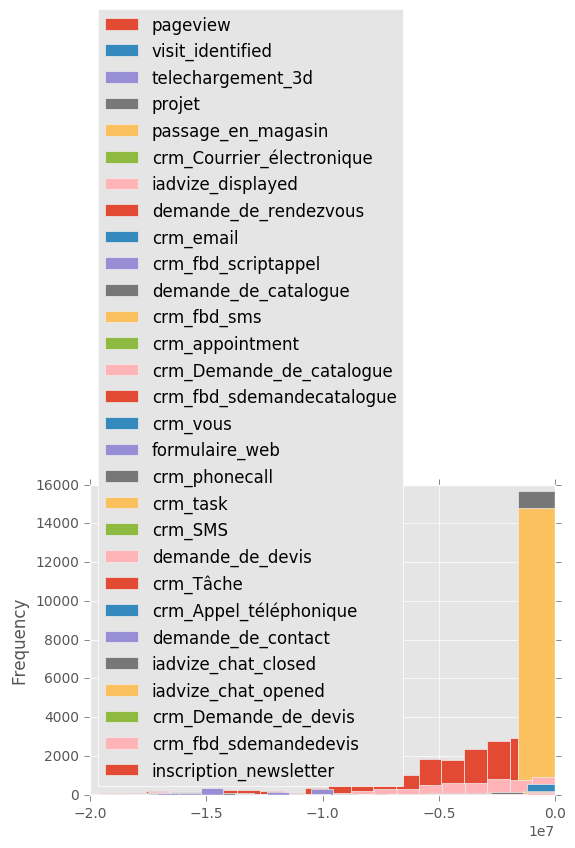

In [43]:
for event in density_data["event"].unique():
    (density_data["timestamp_difference"][density_data["event"]==event]).apply(timedelta.total_seconds).plot(kind='hist',stacked=True,bins=20,label=event,legend='reverse').set_xlim(-20000000,0)
plt.show()

Le nombre d'évenements différents est trop important pour tout étudier comme ça, on regroupe les "crm", les "iadvize" et les "demande" ensemble.

On retire aussi les évenements qui sont évidents tel que l'achat du projet et le passage en magasin le jour J.

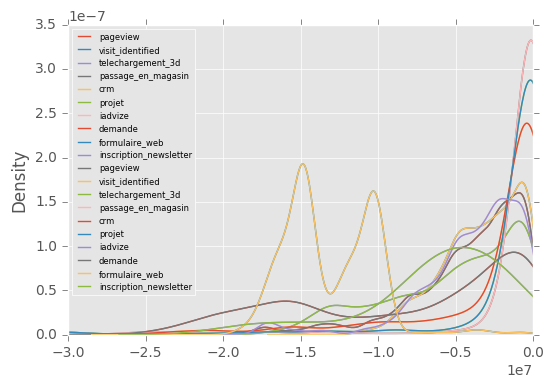

In [46]:
for event in density_data_cleaned["event"].unique():
    (density_data_cleaned["timestamp_difference"][density_data_cleaned["event"]==event]).apply(timedelta.total_seconds).plot(kind="density",use_index=False,legend='reverse',label=event).set_xlim(-30000000,0)
plt.legend(loc=2,prop={'size':6})
plt.show()

Et voilà !